In [7]:
from transformers import GPTJForCausalLM, AutoTokenizer
import torch

# Load the tokenizer and model
model_path = "/home/sjoshi/lmm/lm-train/checkpoints/v3_spatial_grid_gptj/checkpoint-1953"  # Replace with the path where your model is saved
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = GPTJForCausalLM.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

# Define a function to generate text
def generate_text(prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Generate text using the model
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id,
            early_stopping=True
        )
    
    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

In [30]:

from datasets import load_from_disk

# Specify the path to the dataset
dataset_path = '/home/sjoshi/lmm/data/generated/v2_spatial_grid'

# Load the dataset
dataset = load_from_disk(dataset_path)
K = 5

# Display the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1000
    })
})


In [27]:
import re
from tqdm import tqdm 

def parse_answer(text):
    match = re.search(r'A:\s*(.*)', text)
    if match:
        return match.group(1).split('\n')[0]
    return None

def parse_grid(grid_str):
    grid_str = '\n'.join(grid_str.split('\n')[:K])
    rows = grid_str.strip().split('\n')
    grid = [row.strip().split('|') for row in rows]
    # Remove any empty strings resulting from splitting and strip each element
    return [[cell.strip() for cell in row if cell.strip()] for row in grid]

total = 0
correct = 0
accuracy = 0.0
wrong_per_pos = {}
num_grids = 0
pbar = tqdm(dataset['validation'], total=250)
for example in pbar:
    num_grids += 1
    prompt = example["text"].split(']')[0] + '].'
    grid = parse_grid(prompt)
    for i in range(K):
        for j in range(K):
            total += 1
            current_prompt = prompt + f"\nWhat object is in row {i}, column {j}?"
            parsed_answer = parse_answer(generate_text(current_prompt, max_new_tokens=5))
            if parsed_answer == grid[i][j]:
                correct += 1
            else:
                if (i, j) in wrong_per_pos:
                    wrong_per_pos[(i, j)] += 1
                else:
                    wrong_per_pos[(i, j)] = 1
            accuracy = correct / total
            pbar.set_description(f'Accuracy: {accuracy:.3f}')
    if num_grids == 250:
        break

  0%|          | 0/250 [00:00<?, ?it/s]/home/sjoshi/anaconda3/envs/vlm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:433: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Accuracy: 0.378:   1%|          | 2/250 [00:22<30:51,  7.47s/it]

In [28]:
import json

# Specify the path to save the file
file_path = '/home/sjoshi/lmm/lm-train/checkpoints/wrong_per_pos.json'

# Convert tuple keys to strings
wrong_per_pos_str_keys = {str(k): v for k, v in wrong_per_pos.items()}

# Save the dictionary to a JSON file
with open(file_path, 'w') as f:
    json.dump(wrong_per_pos_str_keys, f)

print(f"wrong_per_pos saved to {file_path}")

wrong_per_pos saved to /home/sjoshi/lmm/lm-train/checkpoints/wrong_per_pos.json


In [29]:
import json

# Specify the path to save the file
file_path = '/home/sjoshi/lmm/lm-train/checkpoints/wrong_per_pos.json'

# Load the dictionary from the JSON file
with open(file_path, 'r') as f:
    wrong_per_pos_str_keys = json.load(f)

# Convert string keys back to tuple keys
wrong_per_pos = {eval(k): v for k, v in wrong_per_pos_str_keys.items()}

parsed_grid = [[0 for _ in range(K)] for _ in range(K)]

# Fill the grid with the values from wrong_per_pos
for (row, col), value in wrong_per_pos.items():
    parsed_grid[row][col] = value

print(parsed_grid)

3


IndexError: list assignment index out of range

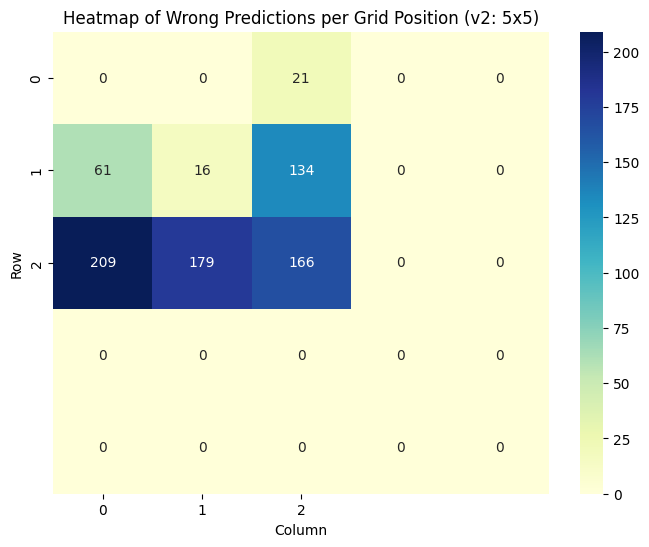

In [17]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Initialize a 3x3 grid with zeros
heatmap_data = np.zeros((5,5))

# Fill the grid with the values from wrong_per_pos
for (row, col), value in wrong_per_pos.items():
    heatmap_data[row, col] = value

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title("Heatmap of Wrong Predictions per Grid Position (v2: 5x5)")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()